This program is used to reshuffle the pnl extracted from mt5 backtest and see what are the possible drawdown, and plot some of them out.

In [1]:
import pandas as pd
# Replace 'your_file.xlsx' with the path to your file
input_file = 'DBG-XAU.xlsx'
# Load the Excel file and skip the first {skiprows} rows
data = pd.read_excel(input_file, skiprows=10757)

/opt/anaconda3/envs/quant/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [2]:
# Select the 'profit' column (assumed to be 'Unnamed: 10') and filter rows as per your instructions
profit_data = data[['Profit','Balance']][1:-1] 
profit_data = profit_data[profit_data.index % 2 == 0]  # Filter for rows with odd indices
profit_data = profit_data.reset_index(drop=True)  # Reset index
# Convert to float, then apply the condition to set values to 1 if > 0, otherwise to 0
profit_data = profit_data.apply(pd.to_numeric, errors='coerce').fillna(0)  # Convert to float, replacing NaN with 0
# Save the processed data to a new CSV file with index
output_csv_path = 'processed-DBG-XAU.csv'
profit_data.to_csv(output_csv_path, index=True, header=['profit_loss','account_balance'])
print(f"Processed data saved to {output_csv_path}")

Processed data saved to processed-DBG-XAU.csv


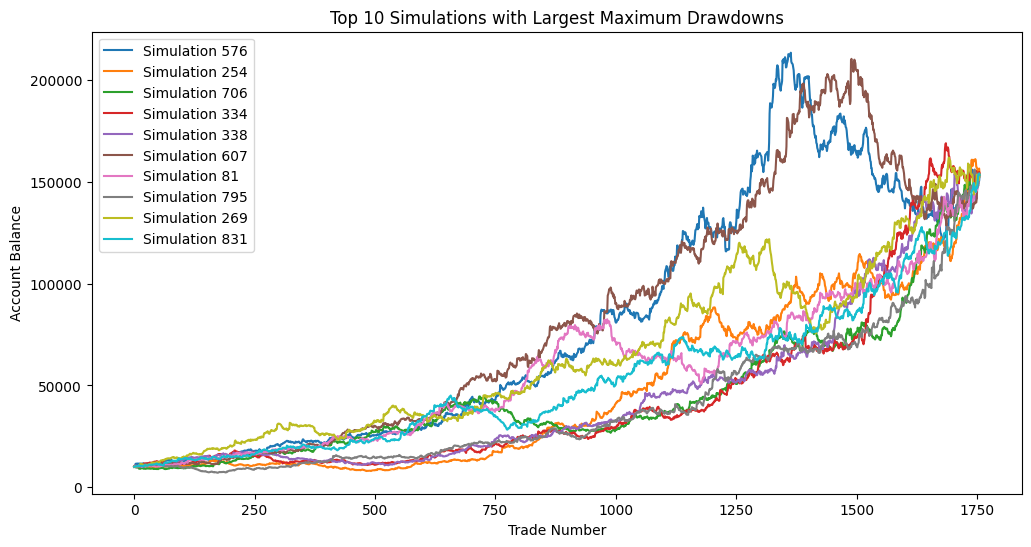

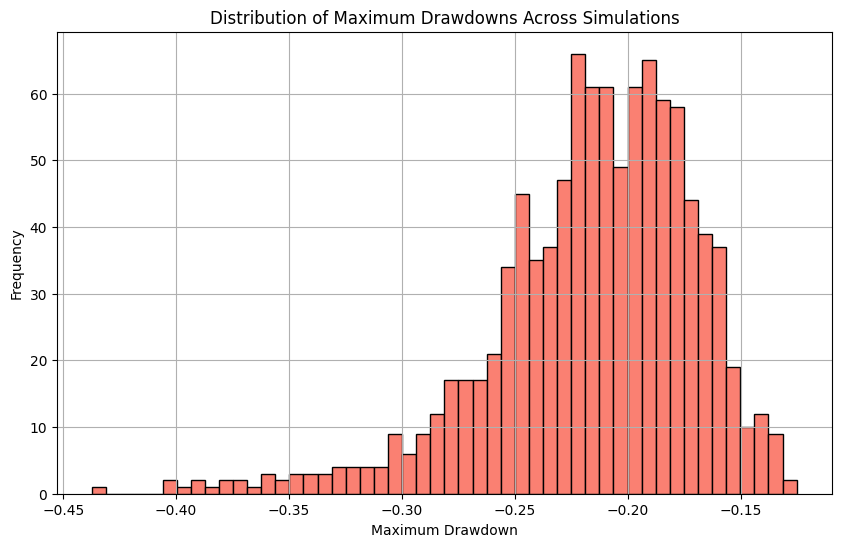

575   -0.437175
253   -0.400842
705   -0.400464
333   -0.394394
337   -0.392838
         ...   
206   -0.133721
128   -0.132000
475   -0.131662
642   -0.130331
335   -0.125271
Name: max_drawdown, Length: 1000, dtype: float64
Simulation 1: Final Equity = 153477.79
Simulation 2: Final Equity = 153477.79
Simulation 3: Final Equity = 153477.79
Simulation 4: Final Equity = 153477.79
Simulation 5: Final Equity = 153477.79
Simulation 6: Final Equity = 153477.79
Simulation 7: Final Equity = 153477.79
Simulation 8: Final Equity = 153477.79
Simulation 9: Final Equity = 153477.79
Simulation 10: Final Equity = 153477.79
Simulation 11: Final Equity = 153477.79
Simulation 12: Final Equity = 153477.79
Simulation 13: Final Equity = 153477.79
Simulation 14: Final Equity = 153477.79
Simulation 15: Final Equity = 153477.79
Simulation 16: Final Equity = 153477.79
Simulation 17: Final Equity = 153477.79
Simulation 18: Final Equity = 153477.79
Simulation 19: Final Equity = 153477.79
Simulation 20: Final Equ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('processed-DBG-XAU.csv')  # Replace 'your_data.csv' with your actual file name

# Assume the CSV has columns 'profit_loss' and 'account_balance'
profit_loss = df['profit_loss']
account_balance = df['account_balance']

# Compute the initial account balance before any trades
initial_balance = account_balance.iloc[0] - profit_loss.iloc[0]

# Calculate the account balance before each trade
account_balance_before_trade = account_balance.shift(1)
account_balance_before_trade.iloc[0] = initial_balance

# Compute the percentage change made to the account balance for each trade
percentage_change = profit_loss / account_balance_before_trade

# Fill any NaN values that might have occurred
percentage_change.fillna(0, inplace=True)

# Number of Monte Carlo simulations
num_simulations = 1000
max_drawdowns = []
equity_curves = []

for _ in range(num_simulations):
    # Shuffle the trade sequence randomly
    shuffled_pct_change = percentage_change.sample(frac=1).reset_index(drop=True)
    
    # Calculate the cumulative returns
    cumulative_returns = (1 + shuffled_pct_change).cumprod()
    
    # Generate the equity curve based on the shuffled trades
    equity_curve = initial_balance * cumulative_returns
    
    # Calculate the running maximum of the equity curve
    running_max = equity_curve.cummax()
    
    # Compute the drawdowns from the running maximum
    drawdown = (equity_curve - running_max) / running_max
    
    # Find the maximum drawdown for this simulation
    max_drawdown = drawdown.min()
    
    # Store the maximum drawdown and corresponding equity curve
    max_drawdowns.append(max_drawdown)
    equity_curves.append(equity_curve)

# Create a DataFrame to store simulation results
results = pd.DataFrame({
    'max_drawdown': max_drawdowns,
    'equity_curve': equity_curves
})

# Sort simulations by maximum drawdown (largest drawdowns first)
results_sorted = results.sort_values(by='max_drawdown')

# Select the top 10 simulations with the largest maximum drawdowns
top_10_drawdowns = results_sorted.head(10)

# Plot the equity curves of the top 10 simulations
plt.figure(figsize=(12, 6))

for idx, row in top_10_drawdowns.iterrows():
    plt.plot(row['equity_curve'].values, label=f'Simulation {idx+1}')

plt.title('Top 10 Simulations with Largest Maximum Drawdowns')
plt.xlabel('Trade Number')
plt.ylabel('Account Balance')
plt.legend()
plt.show()

# Plot a histogram of maximum drawdowns
plt.figure(figsize=(10, 6))
plt.hist(results['max_drawdown'], bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Maximum Drawdowns Across Simulations')
plt.xlabel('Maximum Drawdown')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(results_sorted['max_drawdown'])
# Calculate final equity for all simulations
final_equities = [curve.iloc[-1] for curve in equity_curves]

#The final equity should be the same cuz it euqals to initial balance times all the product of (1+pct)
for i, equity in enumerate(final_equities, start=1):
    print(f"Simulation {i}: Final Equity = {equity:.2f}")

